<a href="https://colab.research.google.com/github/RobotKitchen/AppleCounting/blob/main/Approach2_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt 1: Counting apples with a Convolutional Neural Network



Load libraries as usual...

In [ ]:
from PIL import Image
import math
from pathlib import Path
import numpy as np
import joblib                           #What was this one for?
from keras.preprocessing import image as keras_image
#from keras.applications import vgg16
import pandas as pd                     # Opening the labels file
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras
from keras.models import model_from_json


Load pre-obtained model and weights

In [ ]:

# Load the json file that contains the model's structure
f = Path("/content/model_structure(2).json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights("/content/model_weights(2).h5")

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

Load image to process


In [ ]:
apple_path = "/content/dataset1_front_1201.png"
apple_pic = Image.open(apple_path)

Show image

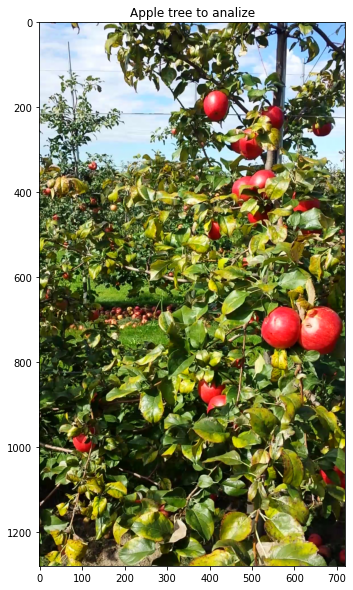

In [ ]:
# Draw the image as a plot
plt.figure(figsize=(10, 10))
plt.imshow(apple_pic, cmap=plt.cm.binary)
plt.title('Apple tree to analize')
# Show the plot on the screen
plt.show()

[link text](https://)### Divide image into 32x32 sub-images

Divider function

In [ ]:
# Function to convert large picture into an n*n array of smaller pictures.
# 1st parameter is image you want to cut up, 2nd parameter is value n in n*n array
def convertToArray(image, arrayNumber):
    # Calculate width and height of each smaller picture
    widthLength = arrayNumber #math.floor(image.size[0] / arrayNumber)
    heightLength = arrayNumber #math.floor(image.size[1] / arrayNumber)
    imagesDict = {}

    # Outer forloop goes through every row, inner forloop goes through every column.
    # Works its way down, row by row
    for i in range(0, image.size[1], heightLength):
        for j in range(0, image.size[0], widthLength):
            if i+heightLength > image.size[1] or j+widthLength > image.size[0]:
                continue
            # box is a tuple of values that determine where to crop the picture. 
            # box gets updated each iteration of the for loop.
            box = (j, i, j + widthLength, i + heightLength)
            
            # Crop the picture and save it to dictionary. 
            # Formatting is just to give the cropped image a somewhat user friendly name.
            imagesDict["cropped_img{}{}{}".format(j,"_",i)] = image.crop(box)
    return imagesDict

*Save images* function

In [ ]:
# For loop iterates through dictionary and saves images as jpg into current directory.
def saveImages(myDict):
    for i in range(len(myDict)):
        list(myDict.values())[i].save("{}.jpg".format(list(myDict.keys())[i]))

Ok, lets divide the images

In [ ]:

sub_images = convertToArray(apple_pic, 64)
#saveImages(sub_images)



Convert to an array usable by keras

In [ ]:

images_test = []

for img_name in list(sub_images.values()):
  #print(img_name)
  # Load the image from disk and process into the VGG format (image.load_img)
  image_array = keras_image.img_to_array(img_name)/255

  # Add the image to the list of images
  images_test.append(image_array)

print('Loading done')

Loading done


In [ ]:

#print(list(sub_images.values())[0])
#for i in range(len(sub_images)):
    # Grab an image from the data set
    #sample_image = images_test[i]
    #image_class_name = labels_test[i,0]
    #image_name = df.Image[i*sub_div]
    #image_path = (apple_path + '/' + img_name)
    
    # Grab the image's expected class id
    #image_class_number = labels_test[i][0]
    # Look up the class name from the class id
    #image_class_name = cifar10_class_names[image_class_number]
  
    # Draw the image as a plot
    #plt.imshow(sample_image, cmap=plt.cm.binary)
    # Label the image
    #plt.title('Pic ' + str(i))
    # Show the plot on the screen
    
    #plt.show()

Make predictions on the individual images

In [ ]:
# Create a single numpy array with all the images we loaded
x_test = np.array(images_test)

# Make a prediction using the model
predictions = model.predict(x_test)


## Show predictions

### Results

In [ ]:
apples_per_pic = np.argmax(predictions, axis=1)
apple_total = sum(apples_per_pic)
print('I think this apple tree has ' + str(apple_total) + ' apples!')




I think this apple tree has 147 apples!


In [ ]:
order_keys = range(0,7)
order_keys = np.tile(order_keys, (len(predictions),1))
apples_per_pic = (np.sum(predictions*order_keys,axis=1))
apples_per_pic = [0 if a_ < 0.01 else a_ for a_ in apples_per_pic] #If confidence is less than 1% set to 0
apples_per_pic = np.ceil(apples_per_pic)
total_apples = sum(apples_per_pic)
#print(total_apples)

### Heatmap

#### Functions

In [ ]:
# Function to apply heatmap to the full picture
def applyHeatmap(listOfImages, listOfPredictions):
  heatmapList = []

  # For loop runs through each individual small image and sets a shade of red
  # depending on how many apples were predicted in that image. The closer to 6,
  # the more red.
  for i in range(len(listOfImages)):
    red_layer = Image.new('RGB', listOfImages[i].size, 'red')
    yellow_layer = Image.new('RGB', listOfImages[i].size, 'yellow')
    strength_layer = Image.blend(yellow_layer, red_layer, (listOfPredictions[i]/6))

    heatmapImage = Image.blend(listOfImages[i], red_layer, (0.5)*(listOfPredictions[i]>0))
    heatmapList.append(heatmapImage)

  return heatmapList

In [ ]:
# Combine all the rows from previous function to create the whole image
def combineRows(rowList):
  
  # Create space for the whole image
  fullImage = Image.new('RGB', (rowList[0][0].size[0], len(rowList) * rowList[0][0].size[1]), (250, 250, 250))

  # for loop runs through all the rows and pastes them one by one vertically the create the full image
  for i in range(len(rowList)):
    fullImage.paste(rowList[i][0], (0, rowList[i][0].size[1] * i))

  return fullImage

In [ ]:
# Function to piece together image rows with the heatmap filter
def finalisePicture(heatmapFilter, originalImage):

  finalPicture = []
  noOfPicsInRow = math.floor((originalImage.size[0]/heatmapFilter[0].size[0]))

  # For loop that goes through each row of heatmap filter images, and appends them
  # to list vertically, creating the full heatmap image
  for i in range(0, (1+(len(heatmapFilter) - noOfPicsInRow)), noOfPicsInRow):
    finalPicture.append(createRow(heatmapFilter, originalImage, i))

  return finalPicture

In [ ]:
# Function to create each row of the whole image, will be pieced together in later function
def createRow(listImages, fullImage, row):
  # Create list to store row image in
  imageRow = []
  
  # Get number of images fit in a row
  noOfPicsInRow = math.floor((fullImage.size[0]/listImages[0].size[0]))

  # Create row space
  new_row = Image.new('RGB', (noOfPicsInRow * listImages[0].size[0], listImages[0].size[1]), (250, 250, 250))
  # i loop adds all pictures on one row
  for i in range(noOfPicsInRow):
    # Paste each small image together to form whole row
    new_row.paste(listImages[row + i], ((listImages[0].size[0] * i),0))
  
  imageRow.append(new_row)

  return imageRow


#### Gen

In [ ]:
order_keys = range(0,7)
order_keys = np.tile(order_keys, (len(predictions),1))
apples_per_pic = (np.sum(predictions*order_keys,axis=1))
apples_per_pic = [0 if a_ < 0.01 else a_ for a_ in apples_per_pic] #If confidence is less than 1% set to 0
apples_per_pic = np.ceil(apples_per_pic)
total_apples = sum(apples_per_pic)
#print(total_apples)

In [ ]:
# Create lists to store images and their associated predictions
imagesList = []
predictionList = []

for i in range(len(x_test)):
    # Grab an image from the data set
    sample_image = images_test[i]
    
    order_keys = range(0,7)
    predictions_i = predictions[i,:]*100
    
    predictions_i = [0 if a_ < 1 else a_ for a_ in predictions_i] #If confidence is less than 1% set to 0

    predictions_i, order_keys = (list(t) for t in zip(*sorted(zip(predictions_i, order_keys), reverse=True)))

    prediction_number = order_keys[0]
    prediction_conf = predictions_i[0]

    #image_class_name = labels_test[i,0]
    #image_name = df.Image[i*sub_div]
    #image_path = (apple_path + '/' + img_name)
    
    # Grab the image's expected class id
    #image_class_number = labels_test[i][0]
    # Look up the class name from the class id
    #image_class_name = cifar10_class_names[image_class_number]
  
    # Draw the image as a plot
#    plt.imshow(sample_image, cmap=plt.cm.binary)
    # Label the image
#    plt.title('Pic ' + str(i) + ' I think this square has ' + str(prediction_number) + ' apples with ' + str(prediction_conf) + '% confidence')
    # Show the plot on the screen
#    plt.show()
#    print(order_keys)
#    print(predictions_i)

    # Append image to the list
    imagesList.append(list(sub_images.values())[i])
    
    # Append the predicted number of apples of the image to this list
    predictionList.append(prediction_number)

In [ ]:
# Create a new list of all small images with the heatmap filter applied
heatmapList = applyHeatmap(imagesList, predictionList)

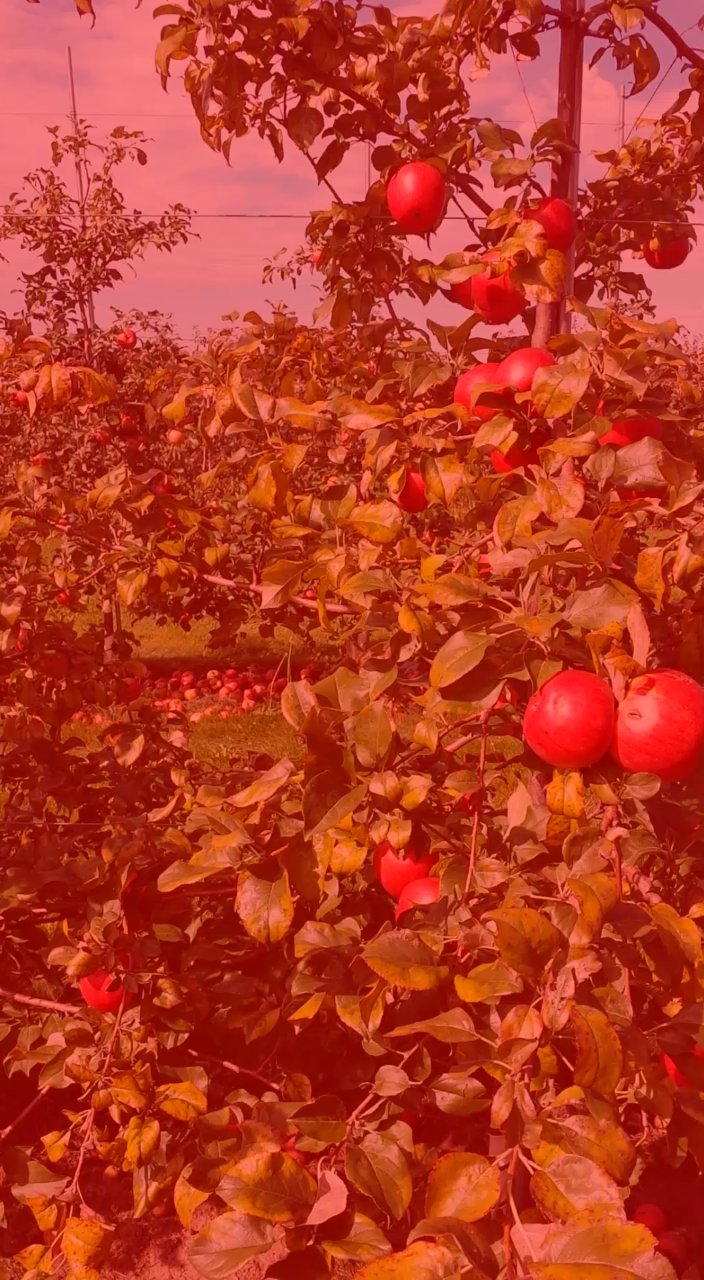

In [ ]:
combineRows(finalisePicture(heatmapList, apple_pic))

#### Small predictions

In [ ]:
for i in range(len(x_test)):
    # Grab an image from the data set
    sample_image = images_test[i]
    
    order_keys = range(0,7)
    predictions_i = predictions[i,:]*100
    
    predictions_i = [0 if a_ < 1 else a_ for a_ in predictions_i] #If confidence is less than 1% set to 0

    predictions_i, order_keys = (list(t) for t in zip(*sorted(zip(predictions_i, order_keys), reverse=True)))

    prediction_number = order_keys[0]
    prediction_conf = predictions_i[0]

    #image_class_name = labels_test[i,0]
    #image_name = df.Image[i*sub_div]
    #image_path = (apple_path + '/' + img_name)
    
    # Grab the image's expected class id
    #image_class_number = labels_test[i][0]
    # Look up the class name from the class id
    #image_class_name = cifar10_class_names[image_class_number]
  
    # Draw the image as a plot
    plt.imshow(sample_image, cmap=plt.cm.binary)
    # Label the image
    plt.title('Pic ' + str(i) + ' I think this square has ' + str(prediction_number) + ' apples with ' + str(prediction_conf) + '% confidence')
    # Show the plot on the screen
    plt.show()
    print(order_keys)
    print(predictions_i)